In [189]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter

In [211]:
basin = 'NI'
# Set directories
project_dir = '/Users/huripari/Documents/PhD/TCs_Genesis'
fs_dir = os.path.join(project_dir, 'FS_TCG')
results_dir = os.path.join(fs_dir, 'results')
# Load csv containing selected variables
cluster_data_info = {'GLB': 'nc12', 'NEP': 'DSnc12', 'NWP': 'Anc10', 'NA': 'DSnc6', 'NI': 'DSnc12', 'SI':'DSnc9', 'SP': 'nc7'}
basin_data_info = cluster_data_info[basin]
n_clusters = int(basin_data_info.split('nc')[1])
if "A" in basin_data_info:
    cluster_data = f'{basin}_{n_clusters}clusters_anomaly'
elif "DS" in basin_data_info:
    cluster_data = f'{basin}_{n_clusters}clusters_deseason'
    target_season = 'target_seasonality_1970-2022_2.5x2.5.csv'
else:
    cluster_data = f'{basin}_{n_clusters}clusters'
data_dir = os.path.join(fs_dir, 'data', cluster_data)
csv_path = os.path.join(results_dir, f'selected_features_best_models_{basin}_{basin_data_info}.csv')
df_perc_sel = pd.read_csv(csv_path, index_col=0)
selected_features = df_perc_sel['80'].dropna().to_list()
# Get the variable names from the selected variables
variables_with_cluster = [var for var in selected_features if 'cluster' in var]
variable_names = [var.split('_cluster')[0] for var in variables_with_cluster]
variable_names = list(set(variable_names))
variable_names.sort()
variable_names

['abs_vo850', 'sst', 'vws850-200']

**Number of atmospheric variables selected for each basin**
- GLB: 6
- NEP: 4
- NWP: 3
- NA: 3
- NI: 3
- SI: 4
- SP: 8

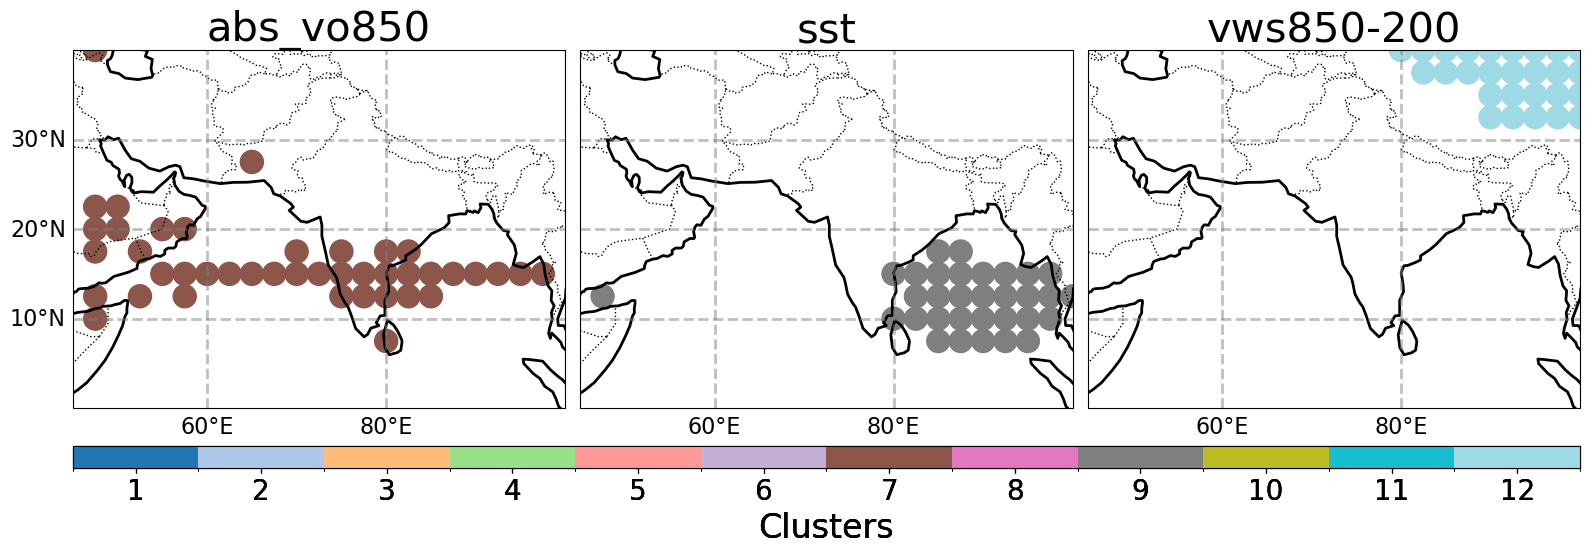

In [212]:
# Set different parameters for each basin figure
if basin == 'NWP':
    west, east, south, north = 100, 180, 0, 40
    fig_basin = plt.figure(figsize=(16, 5.6))
    gs_basin = gridspec.GridSpec(2, 3, figure=fig_basin, height_ratios=[1, 0.05])
    no_lon_label_pos = []
    no_lat_label_pos = [1, 2]
    scatter_size = 275
    bar_position = 3
elif basin == 'NEP':
    west, east, south, north = -180, -75, 0, 40
    fig_basin = plt.figure(figsize=(16, 8.2))
    gs_basin = gridspec.GridSpec(3, 2, figure=fig_basin, height_ratios=[1, 1, 0.05])
    no_lon_label_pos = [0, 1]
    no_lat_label_pos = [1, 3]
    scatter_size = 275
    bar_position = 4
elif basin == 'NA':
    west, east, south, north = -100, 0, 0, 40
    fig_basin = plt.figure(figsize=(16, 5.6))
    gs_basin = gridspec.GridSpec(2, 3, figure=fig_basin, height_ratios=[1, 0.05])
    no_lon_label_pos = []
    no_lat_label_pos = [1, 2]
    scatter_size = 125
    bar_position = 3
elif basin == 'NI':
    west, east, south, north = 45, 100, 0, 40
    fig_basin = plt.figure(figsize=(16, 5.6))
    gs_basin = gridspec.GridSpec(2, 3, figure=fig_basin, height_ratios=[1, 0.05])
    no_lon_label_pos = []
    no_lat_label_pos = [1, 2]
    scatter_size = 275
    bar_position = 3
elif basin == 'SP':
    west, east, south, north = 135, -70, -40, 0
    fig_basin = plt.figure(figsize=(24, 12.6))
    gs_basin = gridspec.GridSpec(5, 2, figure=fig_basin, height_ratios=[1, 1, 1, 1, 0.05])
    no_lon_label_pos = [0, 1, 2, 3, 4, 5]
    no_lat_label_pos = [1, 3, 5, 7]
    scatter_size = 200
    bar_position = 8
elif basin == 'SI':
    west, east, south, north = 35, 135, -40, 0
    fig_basin = plt.figure(figsize=(16, 8.5))
    gs_basin = gridspec.GridSpec(3, 2, figure=fig_basin, height_ratios=[1, 1, 0.05])
    no_lon_label_pos = [0, 1]
    no_lat_label_pos = [1, 3]
    scatter_size = 325
    bar_position = 4
elif basin == 'GLB':
    west, east, south, north = -181, 181, -40, 40
    fig_basin = plt.figure(figsize=(24, 10.5))
    gs_basin = gridspec.GridSpec(4, 2, figure=fig_basin, height_ratios=[1, 1, 1, 0.05])
    no_lon_label_pos = [0, 1, 2, 3]
    no_lat_label_pos = [1, 3, 5]
    scatter_size = 150
    bar_position = 6
else:
    raise ValueError('Basin not recognized')
# Define a color map with fixed colors for each cluster and map the clusters to the colors index
unique_clusters = np.arange(1, n_clusters+1)
cmap = plt.get_cmap('tab20', n_clusters)
colors = cmap(np.linspace(0, 1, n_clusters))
full_cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(np.arange(n_clusters + 1) - 0.5, n_clusters)
cluster_to_color_index = {cluster: i for i, cluster in enumerate(unique_clusters)}
# Cycle through the different variables and plot the clusters
for v, var in enumerate(variable_names):
    # Load the labels file
    label_file = f'labels_{var}.csv'
    label_df = pd.read_csv(os.path.join(data_dir, label_file), index_col=0)
    # Determine the clusters and corresponding lags selected for the variable
    clusters_selected = np.asarray([int(long_name.split('_cluster')[1].split('_lag')[0]) 
                                    for long_name in selected_features if long_name.split('_cluster')[0] == var])
    # Plot the clusters for the selected variable and lag only if there are clusters selected
    if len(clusters_selected) > 0:
        # Select the rows of the label file that correspond to the selected clusters
        label_df_selected = label_df[label_df['cluster'].isin(clusters_selected)]
        # Set the figure and gridlines of the map
        if basin == 'NA':
            ax = fig_basin.add_subplot(gs_basin[v], projection=ccrs.PlateCarree())
            ax.set_extent([west, east, south, north], crs=ccrs.PlateCarree())
        elif basin == 'SP':
            ax = fig_basin.add_subplot(gs_basin[v], projection=ccrs.PlateCarree(central_longitude=180))
            ax.set_extent([west, east, south, north], crs=ccrs.PlateCarree(central_longitude=180))
        else:
            ax = fig_basin.add_subplot(gs_basin[v], projection=ccrs.PlateCarree(central_longitude=180))
            ax.set_extent([west, east, south, north], crs=ccrs.PlateCarree())
        ax.coastlines(resolution='110m', linewidth=2)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        if v in no_lat_label_pos:
            gl.left_labels = False
        if v in no_lon_label_pos:
            gl.bottom_labels = False
        gl.xformatter = LongitudeFormatter()
        gl.yformatter = LatitudeFormatter()
        gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 20))
        gl.ylocator = mticker.FixedLocator(np.arange(-90, 91, 10))
        gl.xlabel_style = {'size': 16} 
        gl.ylabel_style = {'size': 16}
        # Plot only the selected clusters using their index in the full color map
        scatter = ax.scatter(
            label_df_selected['nodes_lon'].values, 
            label_df_selected['nodes_lat'].values,
            c=[cluster_to_color_index[cluster] for cluster in label_df_selected['cluster']],
            cmap=full_cmap, norm=norm, s=scatter_size, transform=ccrs.PlateCarree()
        )
        ax.set_title(f'{var}', fontsize=30)
    # Create a colorbar showing all clusters
    ax_cbar = fig_basin.add_subplot(gs_basin[bar_position:])
    cbar = plt.colorbar(mappable=scatter, cax=ax_cbar, orientation='horizontal', ticks=np.arange(n_clusters))
    cbar.set_ticklabels(unique_clusters)
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label('Clusters', fontsize=24)
    fig_basin.set_tight_layout(True)
# Save the figure
save_path = os.path.join(fs_dir, 'best_model_analysis', 'figures', basin, f'cluster_var_map_{basin}_{basin_data_info}_perc80.pdf')
fig_basin.savefig(save_path, format='pdf', dpi=300, bbox_inches='tight')
plt.show()